In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_percentage_error, r2_score

In [3]:
!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

--2021-11-29 14:00:28--  https://lazyprogrammer.me/course_files/airline_passengers.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2036 (2.0K) [text/csv]
Saving to: ‘airline_passengers.csv’

airline_passengers. 100%[===================>]   1.99K  --.-KB/s    in 0s      

2021-11-29 14:00:29 (32.1 MB/s) - ‘airline_passengers.csv’ saved [2036/2036]



In [4]:
df = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)

In [5]:
df['LogPassengers'] = np.log(df['Passengers'])

In [6]:
df['DiffLogPassengers'] = df['LogPassengers'].diff()

In [7]:
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [8]:
series = df['DiffLogPassengers'].to_numpy()[1:]


T = 10
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (133, 10) Y.shape (133,)


In [9]:
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

In [10]:
lr = LinearRegression()
lr.fit(Xtrain, Ytrain)
lr.score(Xtrain, Ytrain)

0.6837135048453121

In [11]:
lr.score(Xtest, Ytest)

0.6492870172668166

In [12]:
# Boolean index
train_idx = df.index <= train.index[-1]
test_idx = ~train_idx

train_idx[:T+1] = False # first T+1 values are not predictable

In [13]:
# Needed to compute un-differenced predictions
df['ShiftLogPassengers'] = df['LogPassengers'].shift(1)
prev = df['ShiftLogPassengers']

In [14]:
last_train = train.iloc[-1]['LogPassengers']

In [15]:
# 1-step forecast
df.loc[train_idx, 'LR_1step_train'] = prev[train_idx] + lr.predict(Xtrain)
df.loc[test_idx, 'LR_1step_test'] = prev[test_idx] + lr.predict(Xtest)

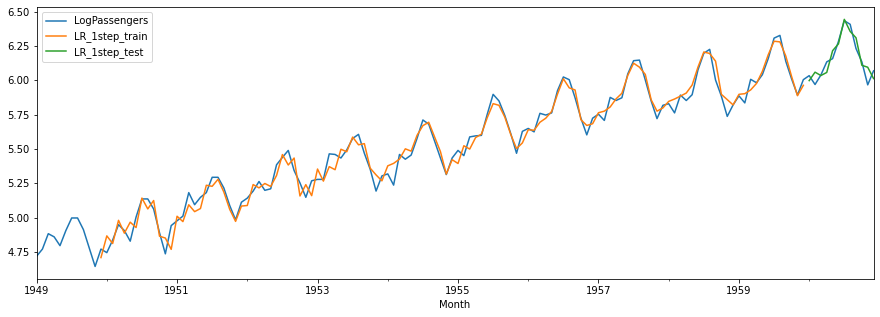

In [16]:
df[['LogPassengers', 'LR_1step_train', 'LR_1step_test']].plot(figsize=(15, 5));

In [17]:
# multi-step forecast
multistep_predictions = []

# first test input
last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
  p = lr.predict(last_x.reshape(1, -1))[0]
  
  # update the predictions list
  multistep_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

In [18]:
df.loc[test_idx, 'LR_multistep'] = last_train + np.cumsum(multistep_predictions)

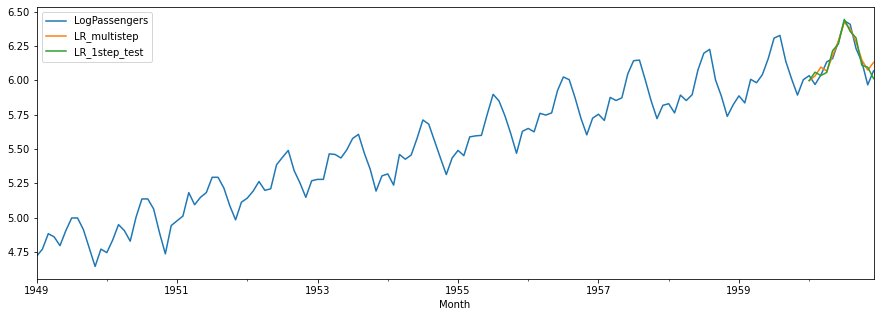

In [19]:
# plot 1-step and multi-step forecast
df[['LogPassengers', 'LR_multistep', 'LR_1step_test']].plot(figsize=(15, 5));

In [20]:
# make multi-output supervised dataset
Tx = T
Ty = Ntest
X = []
Y = []
for t in range(len(series) - Tx - Ty + 1):
  x = series[t:t+Tx]
  X.append(x)
  y = series[t+Tx:t+Tx+Ty]
  Y.append(y)

X = np.array(X).reshape(-1, Tx)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (122, 10) Y.shape (122, 12)


In [21]:
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

In [22]:
lr = LinearRegression()
lr.fit(Xtrain_m, Ytrain_m)
lr.score(Xtrain_m, Ytrain_m)

0.8141637147930583

In [23]:
# save multi-output forecast to dataframe
df.loc[test_idx, 'LR_multioutput'] = last_train + \
  np.cumsum(lr.predict(Xtest_m).flatten())

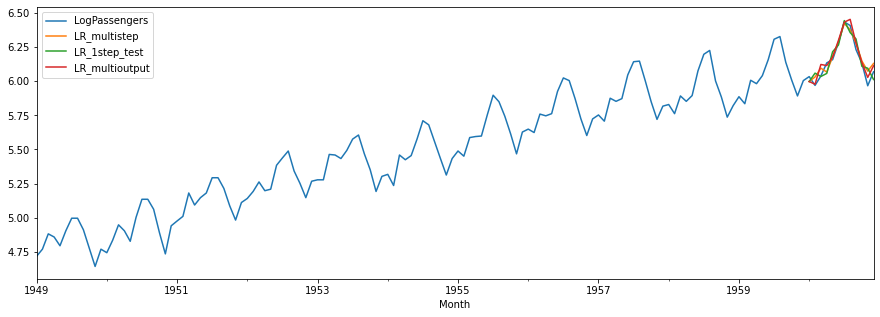

In [24]:
# plot all forecasts
cols = ['LogPassengers', 'LR_multistep', 'LR_1step_test', 'LR_multioutput']
df[cols].plot(figsize=(15, 5));

In [25]:
# MAPE
test_log_pass = df.iloc[-Ntest:]['LogPassengers']
mape1 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'LR_multistep'])
print("multi-step MAPE:", mape1)
mape2 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'LR_multioutput'])
print("multi-output MAPE:", mape2)

multi-step MAPE: 0.007109281288502525
multi-output MAPE: 0.005245261617574867


In [26]:
def one_step_and_multistep_forecast(model, name):
  model.fit(Xtrain, Ytrain)
  print("One-step forecast:", name)
  # print("Train R^2:", model.score(Xtrain, Ytrain))
  # print("Test R^2 (1-step):", model.score(Xtest, Ytest))

  # store 1-step forecast
  df.loc[train_idx, f'{name}_1step_train'] = \
    prev[train_idx] + model.predict(Xtrain)
  df.loc[test_idx, f'{name}_1step_test'] = \
    prev[test_idx] + model.predict(Xtest)

  # generate multi-step forecast
  multistep_predictions = []

  # first test input
  last_x = Xtest[0]

  while len(multistep_predictions) < Ntest:
    p = model.predict(last_x.reshape(1, -1))[0]
    
    # update the predictions list
    multistep_predictions.append(p)
    
    # make the new input
    last_x = np.roll(last_x, -1)
    last_x[-1] = p
  
  # store multi-step forecast
  df.loc[test_idx, f'{name}_multistep_test'] = \
    last_train + np.cumsum(multistep_predictions)

  # MAPE of multi-step forecast
  mape = mean_absolute_percentage_error(
      test_log_pass, df.loc[test_idx, f'{name}_multistep_test'])
  print("Test MAPE (multi-step):", mape)

  # plot 1-step and multi-step forecast
  cols = [
    'LogPassengers',
    f'{name}_1step_train',
    f'{name}_1step_test',
    f'{name}_multistep_test'
  ]
  df[cols].plot(figsize=(15, 5));

One-step forecast: SVR
Test MAPE (multi-step): 0.012149122102392764


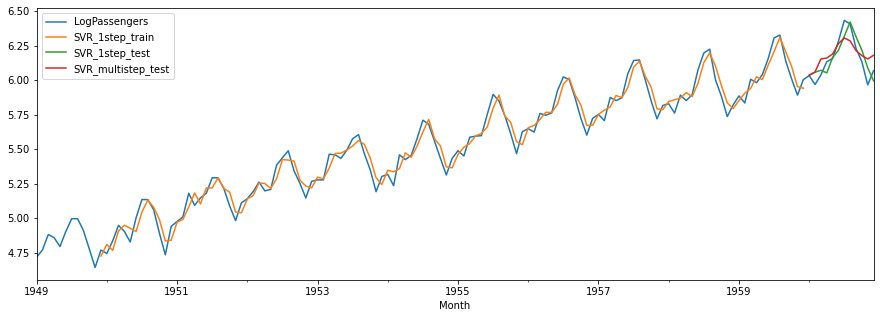

In [27]:
one_step_and_multistep_forecast(SVR(), "SVR")

One-step forecast: RF
Test MAPE (multi-step): 0.00481311583884927


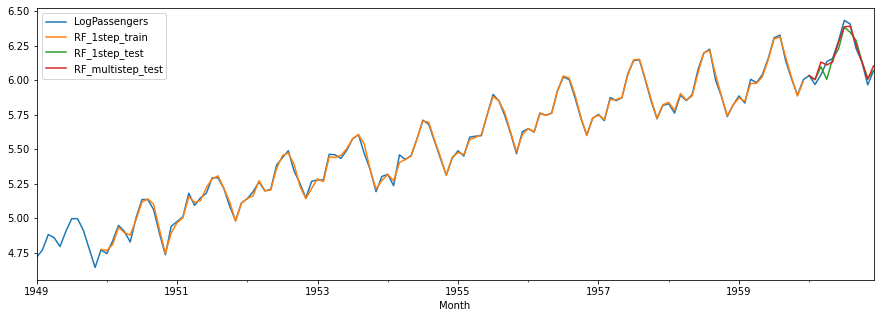

In [28]:
one_step_and_multistep_forecast(RandomForestRegressor(), "RF")

In [29]:
def multi_output_forecast(model, name):
  model.fit(Xtrain_m, Ytrain_m)
  
  # save multi-output forecast to dataframe
  df.loc[test_idx, f'{name}_multioutput'] = \
    last_train + np.cumsum(model.predict(Xtest_m).flatten())
  
  mape = mean_absolute_percentage_error(
      test_log_pass, df.loc[test_idx, f'{name}_multioutput'])
  print("Test MAPE (multi-output):", mape)

  # plot all forecasts
  # assume that previous functions have been run
  cols = [
    'LogPassengers',
    f'{name}_1step_train',
    f'{name}_1step_test',
    f'{name}_multistep_test',
    f'{name}_multioutput',
  ]
  df[cols].plot(figsize=(15, 5));

In [30]:
# multi_output_forecast(SVR(), "SVR") # cannot handle multi-output!

In [31]:
class SVRWrapper:
  def __init__(self, h, **args):
    self.h = h
    self.models = [SVR(**args) for _ in range(h)]
  
  def fit(self, X, Y):
    for k in range(self.h):
      self.models[k].fit(X, Y[:, k])
  
  def predict(self, X):
    P = [m.predict(X) for m in self.models]
    return np.hstack(P)


Test MAPE (multi-output): 0.010731361803536803


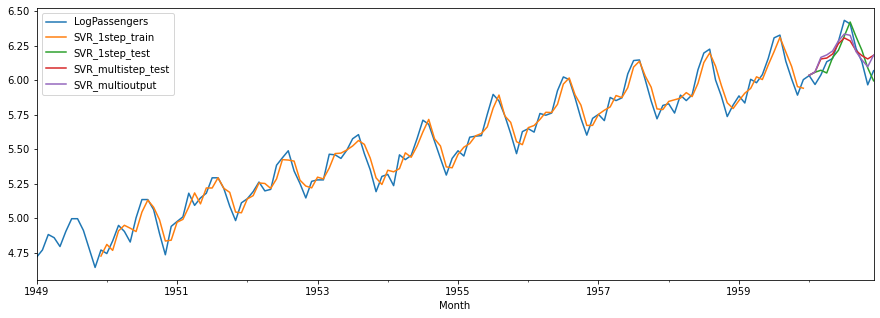

In [32]:
multi_output_forecast(SVRWrapper(Ntest), "SVR")

Test MAPE (multi-output): 0.00524557153092287


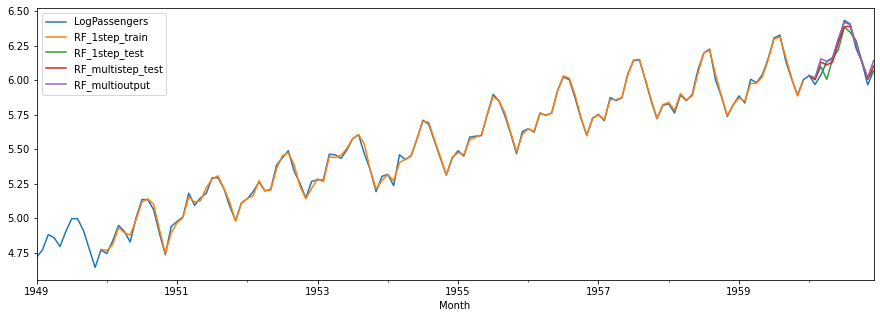

In [33]:
multi_output_forecast(RandomForestRegressor(), "RF")